## Imports<a id='3.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay

## Load The Data<a id='3.4_Load_The_Data'></a>

In [2]:
# import json package
import json

logins_file_path = '../raw_data/logins.json'

# read json file into variable
with open(logins_file_path) as datafile:
    data = json.load(datafile)

# create dataframe
logins_data = pd.DataFrame(data)
logins_data.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


## logins_data dataframe

In [3]:
# Display the first few rows of the data
logins_data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Display the shape of data
logins_data.shape

(93142, 1)

# Part 1 ‐ Exploratory data analysis

### Aggregate these login counts based on 15 minute time intervals

In [5]:
# Ensure the login_time column is in datetime format
logins_data['login_time'] = pd.to_datetime(logins_data['login_time'])

# Set the login_time column as the index
logins_data.set_index('login_time', inplace=True)

# Resample the data to 15-minute intervals and count the number of logins
login_counts_15min = logins_data.resample('15T').size()

# Convert the Series to a DataFrame
login_counts_15min_df = login_counts_15min.to_frame(name='login_count')

# Display the first few rows of the aggregated data
login_counts_15min_df.head(10)

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


In [6]:
# Resample the data to 15-minute intervals and count the logins
login_counts_15min = logins_data.resample('15T').size().reset_index(name='login_count')

# Add additional time features
login_counts_15min['hour'] = login_counts_15min['login_time'].dt.hour
login_counts_15min['day'] = login_counts_15min['login_time'].dt.day
login_counts_15min['week'] = login_counts_15min['login_time'].dt.isocalendar().week
login_counts_15min['month'] = login_counts_15min['login_time'].dt.month
login_counts_15min['quarter'] = login_counts_15min['login_time'].dt.quarter

# Display the resulting DataFrame
login_counts_15min.head()

,login_time,login_count,hour,day,week,month,quarter
0,1970-01-01 20:00:00,2,20,1,1,1,1
1,1970-01-01 20:15:00,6,20,1,1,1,1
2,1970-01-01 20:30:00,9,20,1,1,1,1
3,1970-01-01 20:45:00,7,20,1,1,1,1
4,1970-01-01 21:00:00,1,21,1,1,1,1


The dataset shows login counts at 15-minute intervals on January 1st, 1970, along with extracted time features such as hour, day, week, month, and quarter. This granular data can help identify hourly peaks in user activity, uncover patterns based on the day of the week, and highlight broader trends over weeks, months, and quarters. Such analysis is crucial for understanding user behavior and optimizing service delivery.

### Visualize and describe the resulting time series of login counts

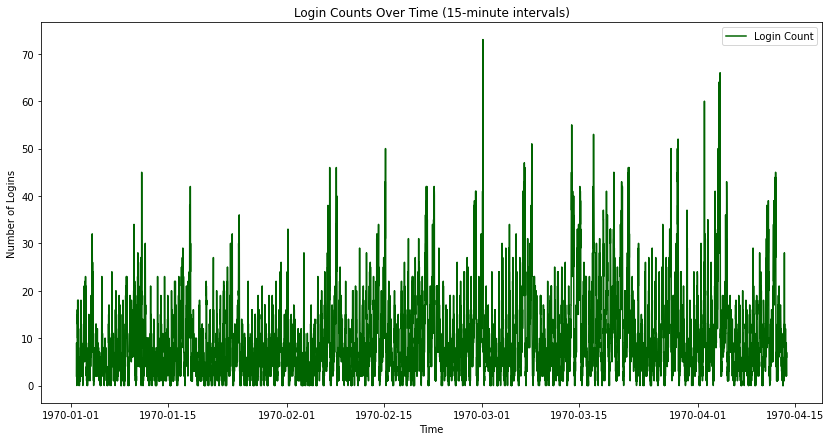

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


# Line Plot: Overall trend
plt.figure(figsize=(14, 7))
sns.lineplot(data=login_counts_15min_df, x=login_counts_15min_df.index, y='login_count', label='Login Count', color = 'darkgreen')
plt.title('Login Counts Over Time (15-minute intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.legend()
plt.show()


The time series plot of login counts over 15-minute intervals shows significant variability in user activity, with frequent spikes indicating periods of high demand. Particularly, there are several peaks reaching up to around 70 logins within some intervals, suggesting times of especially high usage. This variability highlights the importance of understanding temporal patterns to optimize resource allocation and service availability.

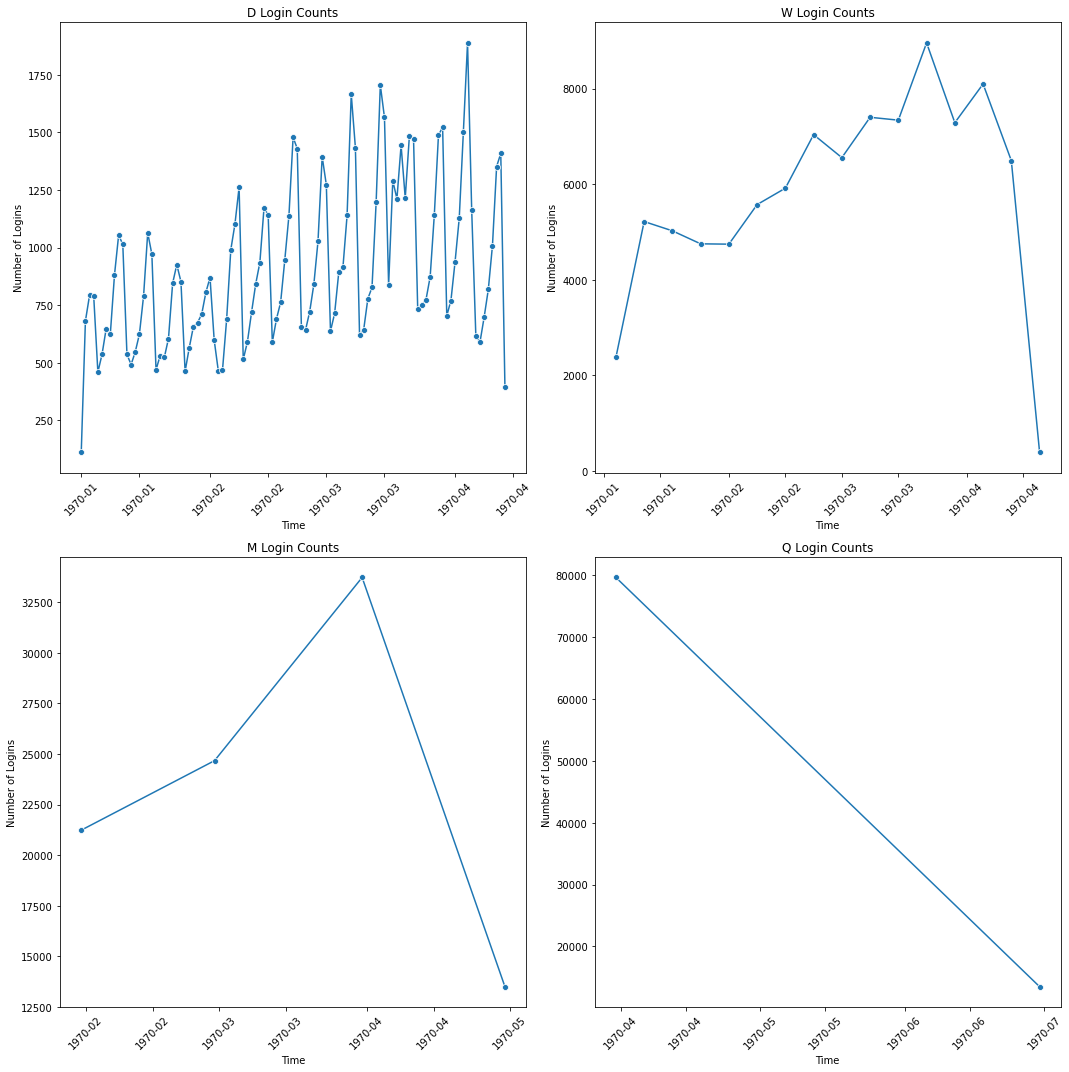

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def plot_login_counts(df, intervals=['D', 'W', 'M', 'Q']):
    """
    intervals: 'D' for daily, 'W' for weekly, 'M' for monthly, 'Q' for quarterly
    """
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.flatten()

    for i, interval in enumerate(intervals):
        # Aggregate the data by the specified interval
        login_counts_aggregated = df.resample(interval).sum().reset_index()

        # Plot the aggregated data
        sns.lineplot(data=login_counts_aggregated, x='login_time', y='login_count', marker='o', ax=axs[i], palette='viridis')
        axs[i].set_title(f'{interval} Login Counts')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Number of Logins')
        
        # Set date format to year-month
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        axs[i].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_login_counts(login_counts_15min_df, ['D', 'W', 'M', 'Q'])


The graphs reveal login counts over different time intervals: daily, weekly, monthly, and quarterly. The daily login counts exhibit a steady upward trend, indicating increasing user engagement over time. The weekly data highlights similar growth with fluctuations that might be due to weekly user behavior patterns. Monthly login counts peak in March before showing a sharp decline, suggesting possible seasonal or event-driven influences on user activity. 

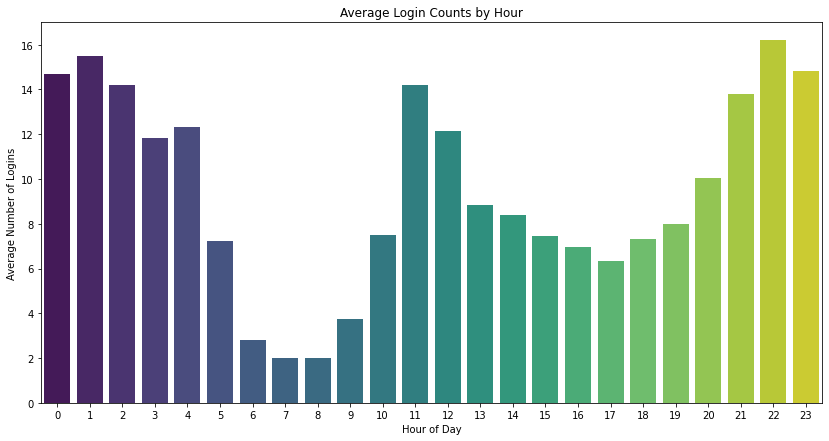

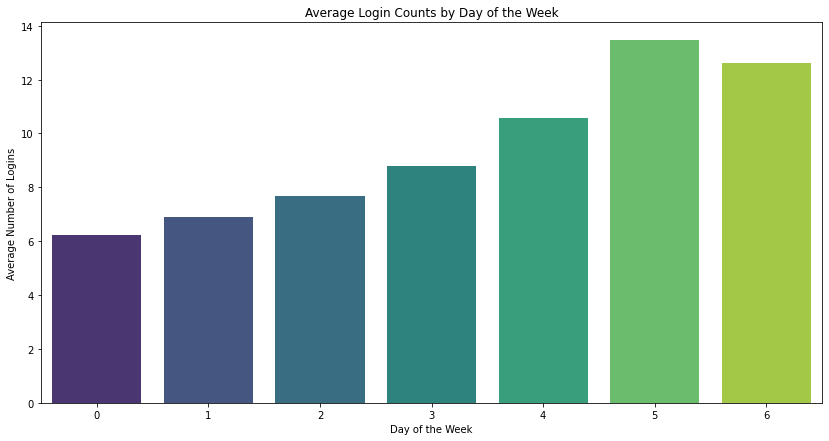

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_login_counts_by_time_feature(df, time_feature):
    # Validate the time feature
    if time_feature not in ['hour', 'day_of_week']:
        raise ValueError("time_feature must be 'hour' or 'day_of_week'")

    # Extract the specified time feature
    if time_feature == 'hour':
        df[time_feature] = df.index.hour
        title = 'Average Login Counts by Hour'
        xlabel = 'Hour of Day'
    elif time_feature == 'day_of_week':
        df[time_feature] = df.index.dayofweek
        title = 'Average Login Counts by Day of the Week'
        xlabel = 'Day of the Week'

    # Aggregate the data by the specified time feature
    aggregated_login_counts = df.groupby(time_feature)['login_count'].mean().reset_index()

    # Bar Chart: Average Login Counts by the specified time feature
    plt.figure(figsize=(14, 7))
    sns.barplot(x=aggregated_login_counts[time_feature], y=aggregated_login_counts['login_count'], palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Average Number of Logins')
    plt.xticks(aggregated_login_counts[time_feature])  # Ensure all time intervals are displayed on the x-axis
    plt.show()

# Example usage for hourly login counts
plot_login_counts_by_time_feature(login_counts_15min_df, 'hour')

# Example usage for login counts by day of the week
plot_login_counts_by_time_feature(login_counts_15min_df, 'day_of_week')


The analysis shows peak login activity late at night around 11 PM and early morning at 2 AM, with a drop between 6 AM and 8 AM, indicating users are most active during late-night hours. There is a notable dip in login activity between 05:00 and 09:00, likely corresponding to typical sleep hours. Logins then pick up again around noon, indicating increased activity during lunch hours. Additionally, login counts increase throughout the week, peaking on Friday and Saturday, reflecting higher user engagement on weekends.

## Part 2 ‐ Experiment and metrics design

### Load the data

In [10]:
# Import json package
import json

logins_file_path = '../raw_data/ultimate_data_challenge.json'

# Read json file into variable
with open(logins_file_path) as datafile:
    data = json.load(datafile)

# Create dataframe
ultimate_data = pd.DataFrame(data)
ultimate_data.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [11]:
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key measure of success for encouraging driver partners to serve both cities would be the retention rate of drivers. This metric is crucial because high retention rates indicate driver satisfaction and engagement, which are essential for maintaining a reliable and consistent service. Retained drivers ensure that there is consistent service availability, reducing rider wait times and improving overall service quality. Additionally, retaining drivers is cost-effective compared to recruiting and training new ones, thus enhancing operational efficiency. Overall, focusing on driver retention reflects the success of initiatives aimed at encouraging drivers to operate in both cities. To measure the "retention rate of drivers" using the provided dataset, the relevant columns would include **signup_date** and **last_trip_date**.

By using these two columns, we can determine if a driver is still active after a certain period. For example, if the last trip date is within a specific time frame (e.g., the past 30, 60, or 90 days), we can consider the driver retained.

In [12]:
# Convert date columns to datetime
ultimate_data['signup_date'] = pd.to_datetime(ultimate_data['signup_date'])
ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data['last_trip_date'])

# Define the most recent date in the dataset
most_recent_date = ultimate_data['last_trip_date'].max()

# Define the retention period (e.g., 30 days)
retention_period = 30

# Calculate the retention
ultimate_data['retained'] = ultimate_data['last_trip_date'] >= (most_recent_date - pd.Timedelta(days=retention_period))

# Calculate the retention rate
retention_rate = ultimate_data['retained'].mean()

print(f"Driver Retention Rate: {retention_rate:.2%}")


Driver Retention Rate: 37.61%


### Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**
### - how you will implement the experiment 
### - what statistical test(s) you will conduct to verify the significance of the observation
### - how you would interpret the results and provide recommendations to the city operations team along with any caveats.

To compare the effectiveness of the proposed incentive program aimed at increasing driver retention, I would design an experiment involving a treatment group (drivers receiving the new incentive) and a control group (drivers under the existing system). Over a period of 30, 60, and 90 days, data on driver activity and retention rates will be collected. Statistical tests, including chi-square tests for comparing retention proportions and t-tests for mean retention rates, will be conducted to determine the significance of any observed differences.

If the results show a statistically significant increase in retention rates for the treatment group, this would indicate the success of the incentive program. In this case, I would recommend implementing the program for all drivers, while highlighting the expected benefits and potential costs. However, if no significant difference is found, I would suggest revisiting the program design or exploring alternative strategies. It's essential to consider external factors, ensure generalizability, and monitor long-term effects to sustain the program's impact.

## Part 3 ‐ Predictive modeling

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?


### Data Exploration

In [13]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  retained                50000 non-null  bool  

In [14]:
ultimate_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


The provided descriptive statistics indicate several insights into user behavior. On average, users take about 2.28 trips in the first 30 days, with significant variability. The average ratings for drivers are high, at 4.60 out of 5, indicating general user satisfaction. Surge pricing is relatively uncommon, with only 8.85% of trips involving a surge multiplier. Additionally, most trips occur on weekdays, comprising approximately 60.93% of all trips, and the average trip distance is around 5.80 miles.

In [15]:
ultimate_data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

The data summary reveals that the 'avg_rating_of_driver' column has 8,122 missing values, the 'phone' column has 396 missing values, and the 'avg_rating_by_driver' column has 201 missing values, while all other columns have no missing values.

In [16]:
ultimate_data[ultimate_data.duplicated()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0,False
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0,False
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0,False
34641,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0,False
36627,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0,False
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0,False
42025,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0,False
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0,False


In [17]:
ultimate_data[ultimate_data.duplicated()].shape

(8, 13)

The dataset contains 8 columns with duplicate values.

### Distribution of categorical variables

In [18]:
categorical_columns = ['city', 'phone', 'ultimate_black_user']
for col in categorical_columns:
    print('-'*10, col,'-'*10)
    print(ultimate_data[col].value_counts(), '\n')

---------- city ----------
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64 

---------- phone ----------
iPhone     34582
Android    15022
Name: phone, dtype: int64 

---------- ultimate_black_user ----------
False    31146
True     18854
Name: ultimate_black_user, dtype: int64 



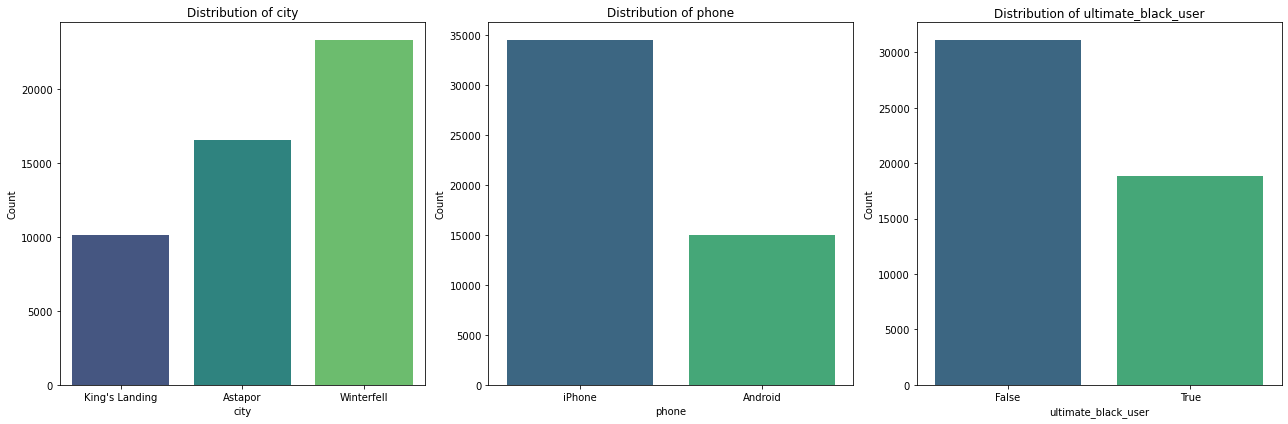

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_distributions(df, categorical_columns):
    
    plt.figure(figsize=(18, 6))  # Adjusting figure size for better readability

    for i, column in enumerate(categorical_columns, 1):        
        plt.subplot(1, 3, i)
        sns.countplot(x=column, data=df, palette='viridis')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Example usage
categorical_columns = ['city', 'phone', 'ultimate_black_user']
plot_categorical_distributions(ultimate_data, categorical_columns)


### Box plots to identify outliers in numerical features

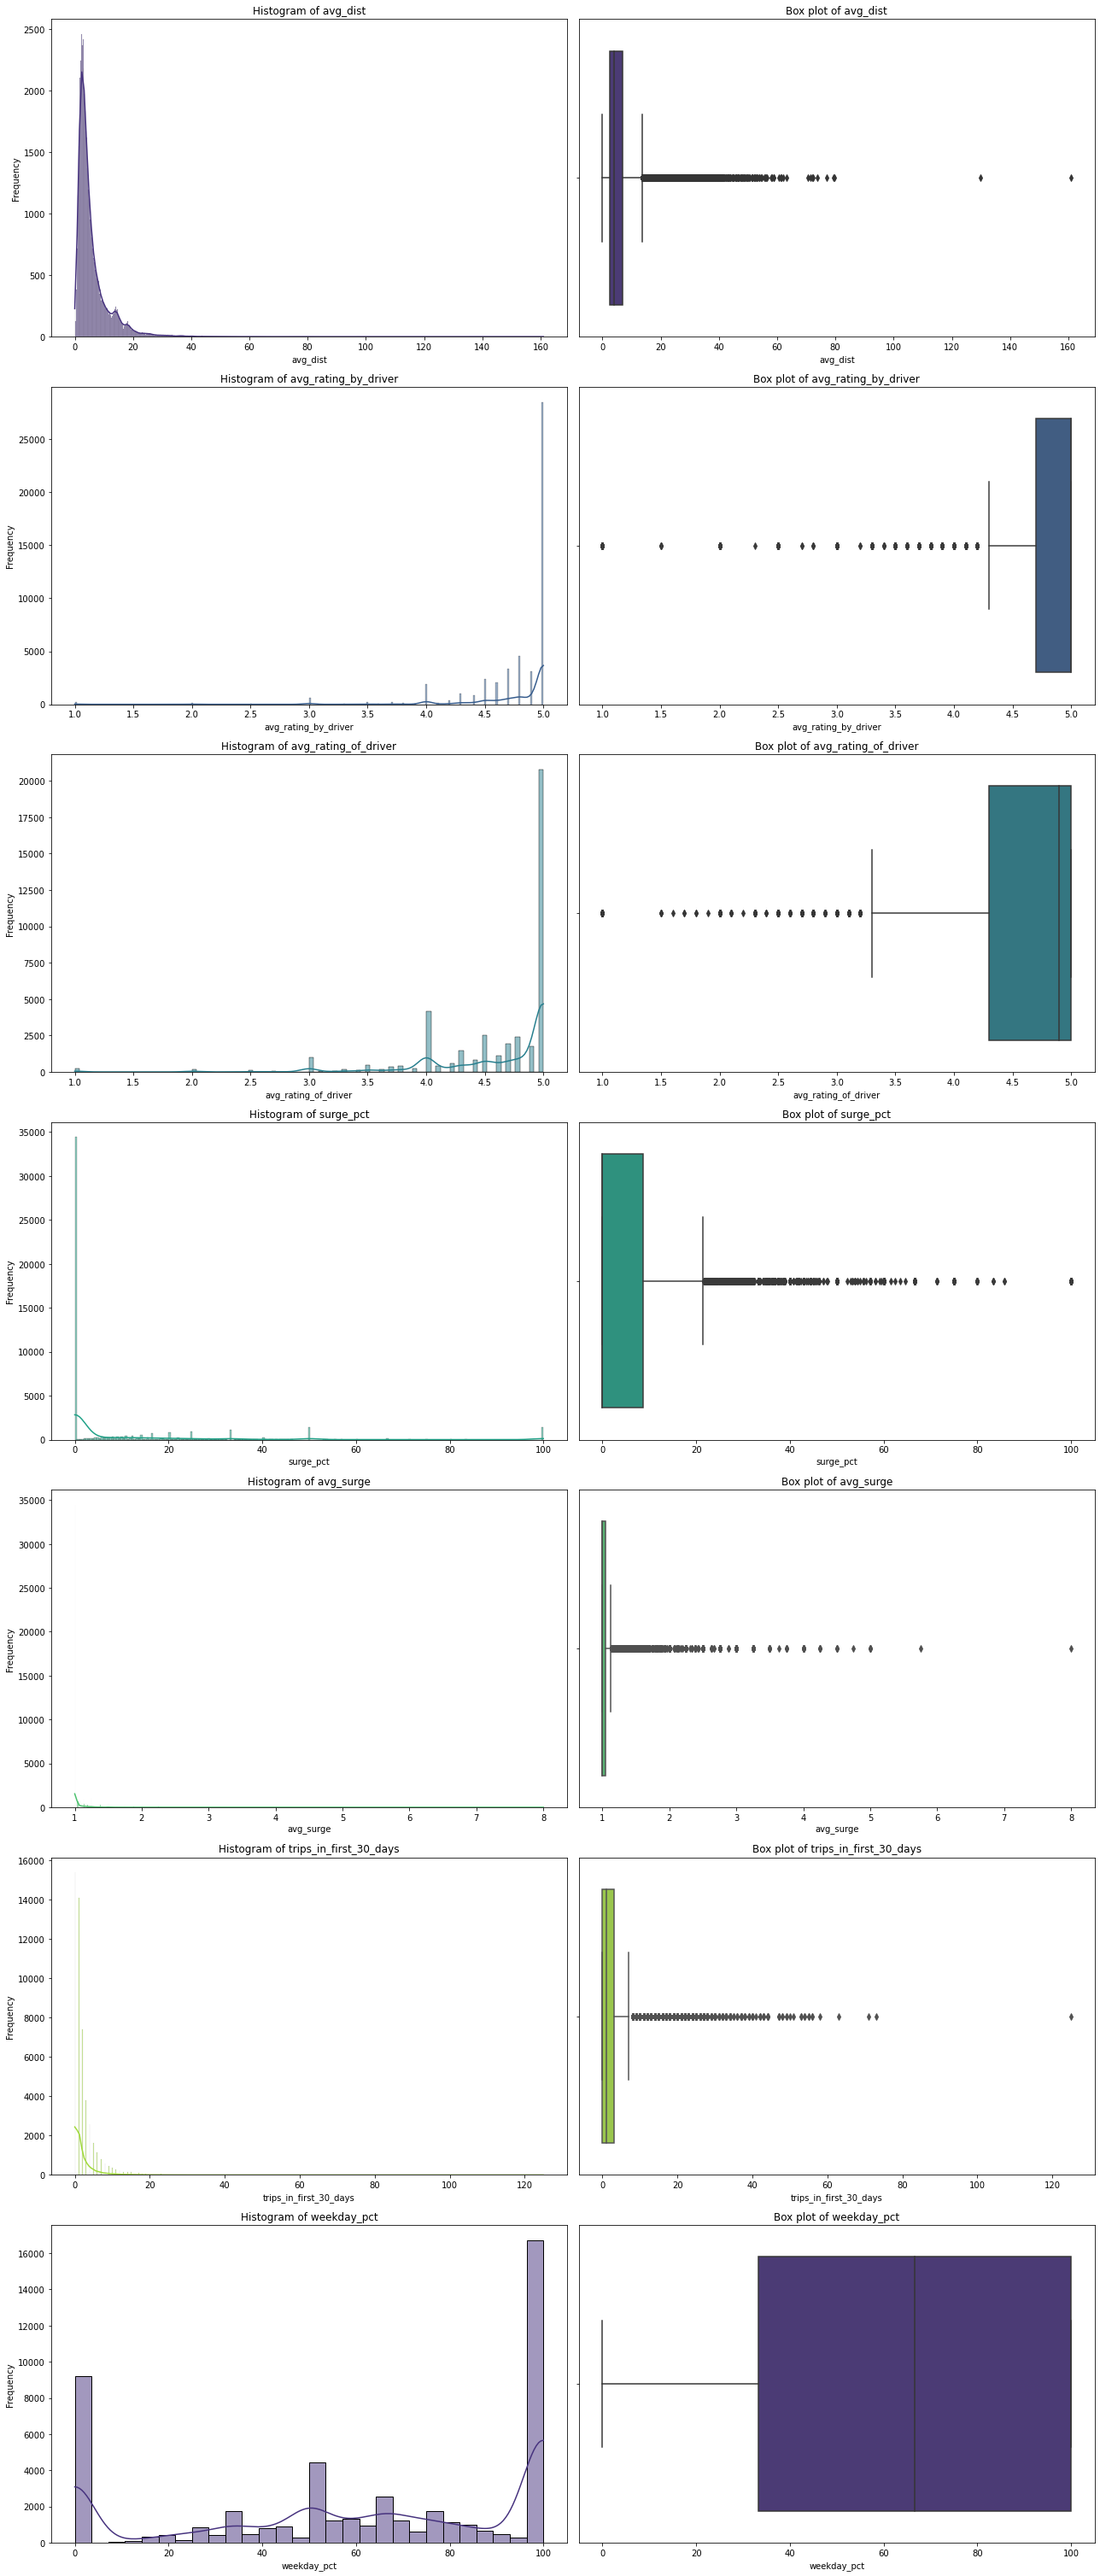

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numerical_distributions(df, numerical_columns):
    # Set the color palette to 'viridis'
    sns.set_palette('viridis')

    num_cols = len(numerical_columns)
    
    # Plot histograms
    plt.figure(figsize=(18, 6 * num_cols))
    for i, column in enumerate(numerical_columns):
        plt.subplot(num_cols, 2, 2 * i + 1)
        sns.histplot(df[column], kde=True, color=sns.color_palette('viridis')[i % len(sns.color_palette('viridis'))])
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        plt.subplot(num_cols, 2, 2 * i + 2)
        sns.boxplot(x=df[column], color=sns.color_palette('viridis')[i % len(sns.color_palette('viridis'))])
        plt.title(f'Box plot of {column}')
        plt.xlabel(column)
    
    plt.tight_layout()
    plt.show()

# Example usage
numerical_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'weekday_pct']
plot_numerical_distributions(ultimate_data, numerical_columns)


Some columns contain outliers that can be removed to improve the dataset's overall quality and analysis accuracy.

### Remove Outliers

In [21]:
import pandas as pd

def remove_outliers(df, numerical_columns):
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

# Example usage
numerical_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'weekday_pct']
cleaned_data = remove_outliers(ultimate_data, numerical_columns)


### Correlation matrix

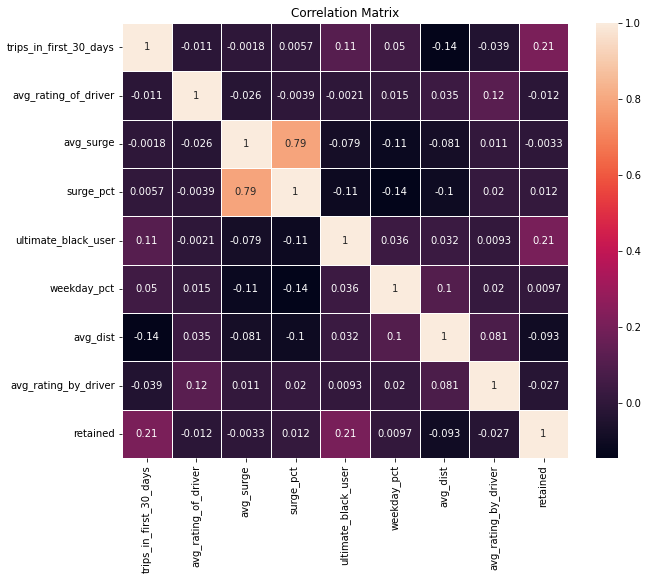

In [22]:
plt.figure(figsize=(10, 8))
corr_matrix = ultimate_data.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix indicates strong positive relationships among the retention-related columns (retained, retained_30_days, retained_60_days, and retained_90_days), highlighting that users retained at different intervals are closely related. Additionally, surge-related variables (avg_surge and surge_pct) are highly correlated, suggesting users who experience higher average surge multipliers also have a higher percentage of trips with surge pricing. There is also a moderate positive correlation between being active in the 6th month and overall retention, showing that long-term active users tend to have higher retention rates. Lastly, the correlations between avg_rating_by_driver and other variables are relatively low, indicating minimal impact of driver ratings on other factors.

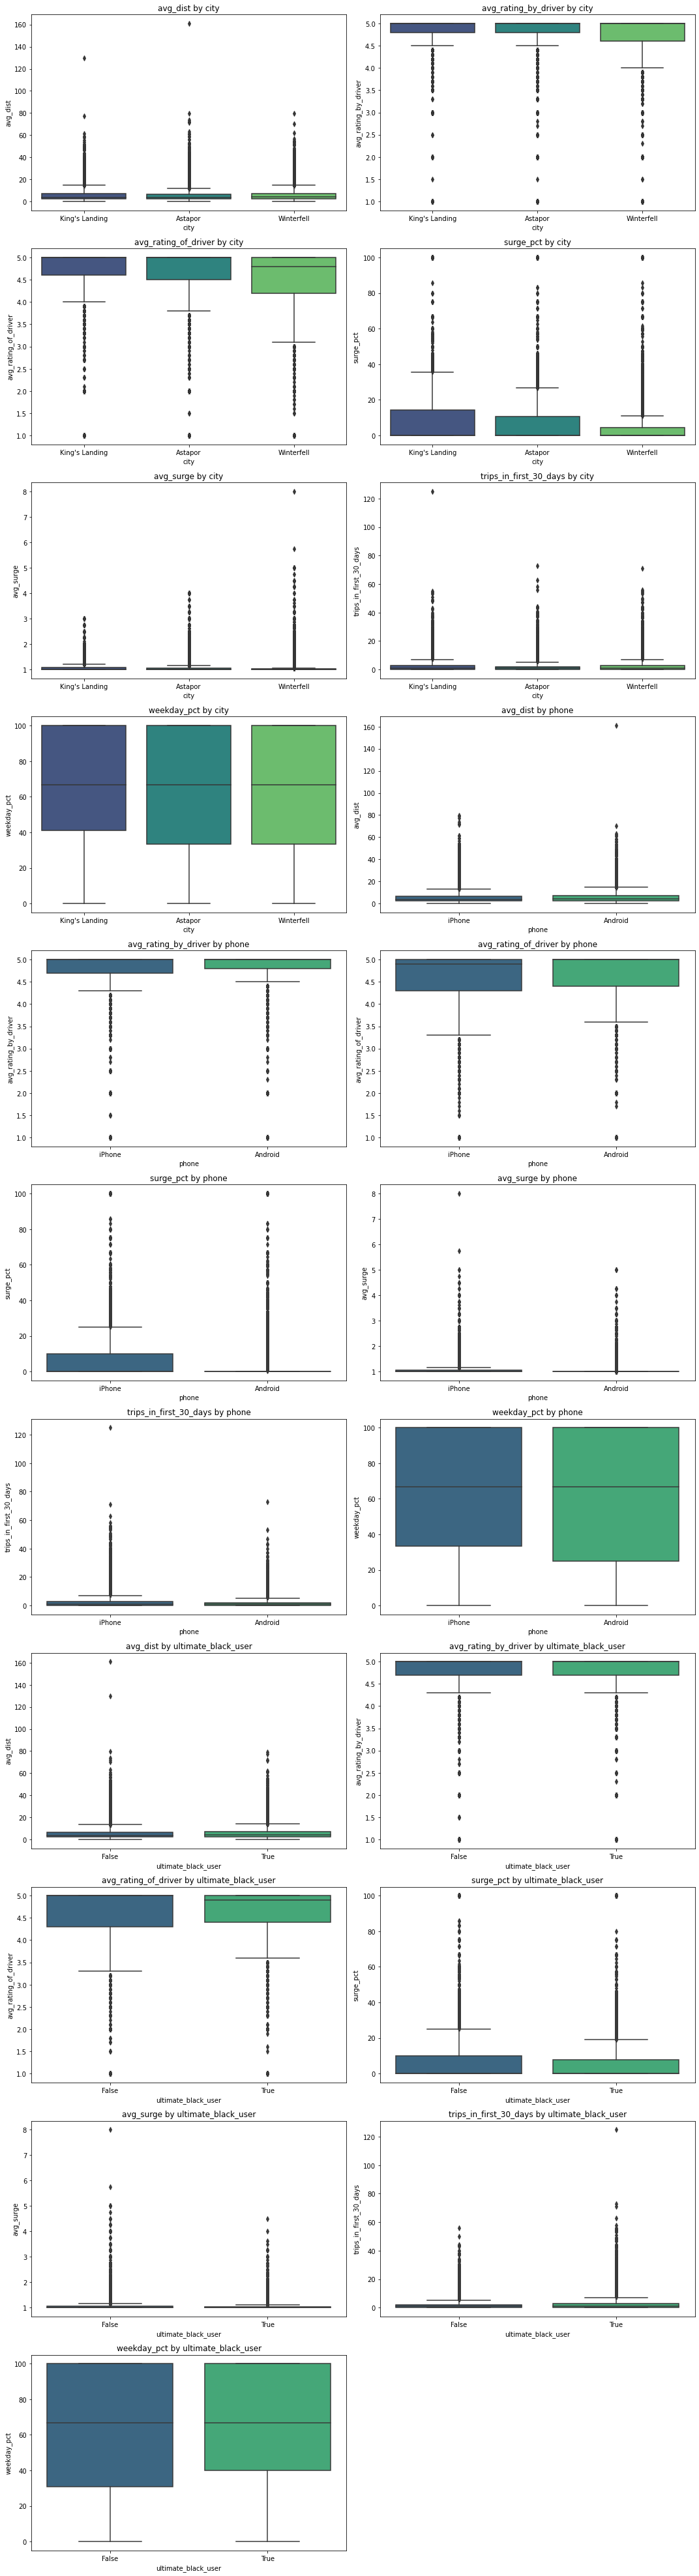

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_vs_numerical(df, categorical_columns, numerical_columns):
    num_categorical = len(categorical_columns)
    num_numerical = len(numerical_columns)
    
    # Define the number of columns per row
    cols_per_row = 2
    rows = num_categorical * num_numerical // cols_per_row + (num_categorical * num_numerical % cols_per_row > 0)
    
    fig, axs = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    plot_number = 0
    for i, cat_col in enumerate(categorical_columns):
        for j, num_col in enumerate(numerical_columns):
            sns.boxplot(x=cat_col, y=num_col, data=df, ax=axs[plot_number], palette='viridis')
            axs[plot_number].set_title(f'{num_col} by {cat_col}')
            axs[plot_number].set_xlabel(cat_col)
            axs[plot_number].set_ylabel(num_col)
            plot_number += 1

    # Hide any unused subplots
    for k in range(plot_number, len(axs)):
        fig.delaxes(axs[k])
    
    plt.tight_layout()
    plt.show()

# Example usage
categorical_columns = ['city', 'phone', 'ultimate_black_user']
numerical_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'weekday_pct']
plot_categorical_vs_numerical(ultimate_data, categorical_columns, numerical_columns)


From the box plots, we can observe the distributions of various numerical features across different categories. For the city variable, avg_dist, avg_rating_of_driver, avg_rating_by_driver, and surge_pct show distinct distributions across different cities, indicating potential city-based differences in user behavior. For the phone variable, there are noticeable variations in avg_dist, avg_rating_by_driver, and surge_pct, suggesting that user experiences might differ based on the type of phone used. For the ultimate_black_user variable, avg_rating_of_driver and weekday_pct have visible differences, indicating that users of Ultimate Black service might have different interaction patterns compared to others. The presence of outliers across multiple features suggests that there are users with extreme values, which might need further investigation.

In [24]:
import pandas as pd

def calculate_retention_rate(df, days):
    # Ensure the date columns are in datetime format
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

    # Calculate the retention rate
    df['retained'] = (df['last_trip_date'] - df['signup_date']).dt.days > days
    retention_rate = df['retained'].mean() * 100  # Convert to percentage

    return retention_rate


retention_30_days = calculate_retention_rate(ultimate_data, 30)
retention_60_days = calculate_retention_rate(ultimate_data, 60)
retention_90_days = calculate_retention_rate(ultimate_data, 90)

print(f'Retention rate after 30 days: {retention_30_days:.2f}%')
print(f'Retention rate after 60 days: {retention_60_days:.2f}%')
print(f'Retention rate after 90 days: {retention_90_days:.2f}%')


Retention rate after 30 days: 73.95%
Retention rate after 60 days: 65.87%
Retention rate after 90 days: 56.99%


  signup_date last_trip_date  retained_30_days  retained_60_days  \
0  2014-01-25     2014-06-17              True              True   
1  2014-01-29     2014-05-05              True              True   
2  2014-01-06     2014-01-07             False             False   
3  2014-01-10     2014-06-29              True              True   
4  2014-01-27     2014-03-15              True             False   

   retained_90_days  
0              True  
1              True  
2             False  
3              True  
4             False  


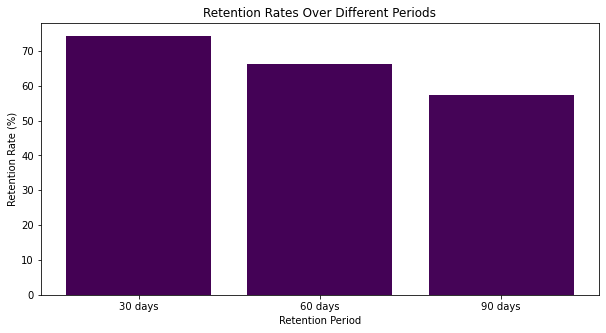

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_retention_rate(df, retention_periods):
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    most_recent_date = df['last_trip_date'].max()
    
    for period in retention_periods:
        column_name = f'retained_{period}_days'
        df[column_name] = (df['last_trip_date'] >= (df['signup_date'] + pd.Timedelta(days=period)))
        
    return df

# Example usage
retention_periods = [30, 60, 90]
ultimate_data_with_retention = calculate_retention_rate(ultimate_data, retention_periods)

# Display the first few rows with retention columns
print(ultimate_data_with_retention[['signup_date', 'last_trip_date', 'retained_30_days', 'retained_60_days', 'retained_90_days']].head())

# Function to plot retention rates
def plot_retention_rates(df, retention_periods):
    retention_rates = [(df[f'retained_{period}_days'].mean() * 100) for period in retention_periods]
    plt.figure(figsize=(10, 5))
    colors = plt.get_cmap('viridis')(range(len(retention_periods)))
    plt.bar(['30 days', '60 days', '90 days'], retention_rates, color=colors)
    plt.xlabel('Retention Period')
    plt.ylabel('Retention Rate (%)')
    plt.title('Retention Rates Over Different Periods')
    plt.show()

# Plot retention rates
plot_retention_rates(ultimate_data_with_retention, retention_periods)


This shows a gradual decline in retention rates as time progresses, with a significant drop between each period. Initially, after 30 days, the retention rate is relatively high at nearly 74%, but by 90 days, it falls to just under 57%. This indicates that while a majority of drivers remain active within the first month, the retention significantly decreases as the months progress. This pattern suggests a need for strategies to maintain driver engagement and satisfaction over longer periods to improve long-term retention rates.

In [26]:
# Display the first few rows with retention columns
print("\nDataFrame with retention columns:")
print(ultimate_data[['signup_date', 'last_trip_date', 'retained_30_days', 'retained_60_days', 'retained_90_days']].head())


DataFrame with retention columns:
  signup_date last_trip_date  retained_30_days  retained_60_days  \
0  2014-01-25     2014-06-17              True              True   
1  2014-01-29     2014-05-05              True              True   
2  2014-01-06     2014-01-07             False             False   
3  2014-01-10     2014-06-29              True              True   
4  2014-01-27     2014-03-15              True             False   

   retained_90_days  
0              True  
1              True  
2             False  
3              True  
4             False  


### Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [27]:
# Load and preprocess data
ultimate_data['signup_date'] = pd.to_datetime(ultimate_data['signup_date'])
ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data['last_trip_date'])

In [28]:
# Create target variable
ultimate_data['active_in_6th_month'] = (ultimate_data['last_trip_date'] - ultimate_data['signup_date']).dt.days >= 150

## Encode categorical variables

In [29]:
le = LabelEncoder()
ultimate_data['city'] = le.fit_transform(ultimate_data['city'])
ultimate_data['phone'] = le.fit_transform(ultimate_data['phone'])
ultimate_data['ultimate_black_user'] = le.fit_transform(ultimate_data['ultimate_black_user'])

## Fill missing values

In [30]:
ultimate_data.fillna(ultimate_data.mean(), inplace=True)

C:\Users\armeh\AppData\Local\Temp\ipykernel_41952\3833050221.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ultimate_data.fillna(ultimate_data.mean(), inplace=True)


## Train/Test Split

In [31]:
# Split data
X = ultimate_data.drop(['signup_date', 'last_trip_date', 'active_in_6th_month'], axis=1)
y = ultimate_data['active_in_6th_month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale features

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest model

In [33]:
# Train 
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

In [34]:
# Evaluate the model
print("Random Forest Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Model:
Accuracy: 0.7934
Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.86      0.86      7435
        True       0.60      0.59      0.60      2565

    accuracy                           0.79     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.79      0.79      0.79     10000

Confusion Matrix:
 [[6414 1021]
 [1045 1520]]


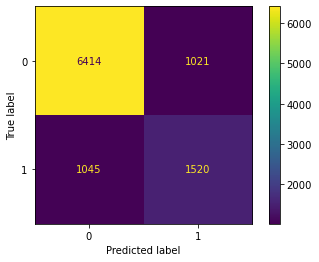

In [35]:
# Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The Random Forest model shows an accuracy of 79.34%, indicating that it correctly classifies the majority of instances. The precision for detecting 'True' class (Churn) is 0.60, meaning that 60% of the predicted churns were correct. The recall for the 'True' class is 0.59, suggesting that 59% of actual churns were correctly identified. The confusion matrix reveals that there are 1,045 false negatives and 1,021 false positives. These metrics indicate that while the model is fairly effective, it may still benefit from further tuning to improve recall and reduce false negatives.

## Gradient Boosting

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb.predict(X_test)

In [37]:
# Evaluate the model
print("Gradient Boosting Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Model:
Accuracy: 0.8155
Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.89      0.88      7435
        True       0.66      0.59      0.62      2565

    accuracy                           0.82     10000
   macro avg       0.76      0.74      0.75     10000
weighted avg       0.81      0.82      0.81     10000

Confusion Matrix:
 [[6643  792]
 [1053 1512]]


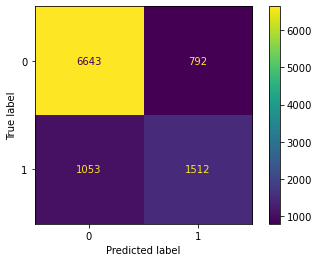

In [38]:
# Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The gradient boosting model has achieved an accuracy of 81.55%, which is higher compared to the random forest model's accuracy of 79.34%. The precision and recall for predicting the "True" class (churn) in the gradient boosting model are 0.66 and 0.59, respectively, indicating a balanced performance in identifying actual churners. The confusion matrix shows 6643 true negatives, 792 false positives, 1512 true positives, and 1053 false negatives, suggesting the model performs well in correctly identifying non-churners and has a moderate rate of false negatives and positives. Overall, the gradient boosting model demonstrates strong predictive capabilities, particularly for the non-churn class, with slightly better performance metrics compared to the random forest model.

## Neural Network

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense


# Ensure date columns are of datetime type
ultimate_data['signup_date'] = pd.to_datetime(ultimate_data['signup_date'])
ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data['last_trip_date'])

# Create target variable and feature set
y = ultimate_data['active_in_6th_month']

# Drop non-numeric columns and target variable from the feature set
X = ultimate_data.drop(['active_in_6th_month', 'signup_date', 'last_trip_date'], axis=1)

# Ensure remaining columns are numeric
X = X.select_dtypes(include=[np.number])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Predict on the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

Epoch 1/50


C:\Users\armeh\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7656 - loss: 0.4978 - val_accuracy: 0.7785 - val_loss: 0.4655
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7858 - loss: 0.4566 - val_accuracy: 0.7868 - val_loss: 0.4513
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7910 - loss: 0.4479 - val_accuracy: 0.7897 - val_loss: 0.4497
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7932 - loss: 0.4424 - val_accuracy: 0.7869 - val_loss: 0.4466
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7938 - loss: 0.4384 - val_accuracy: 0.7841 - val_loss: 0.4522
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7951 - loss: 0.4385 - val_accuracy: 0.7922 - val_loss: 0.4425
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7957 - loss: 0.4367 - val_accuracy: 0.7847 - val_loss: 0.4470
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7940 - loss: 0.4389 - val_accurac

In [40]:
# Evaluate the model
print("Neural Network Model:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Neural Network Model:
Accuracy: 0.7913
Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.91      0.87      7435
        True       0.64      0.44      0.52      2565

    accuracy                           0.79     10000
   macro avg       0.73      0.68      0.69     10000
weighted avg       0.78      0.79      0.78     10000



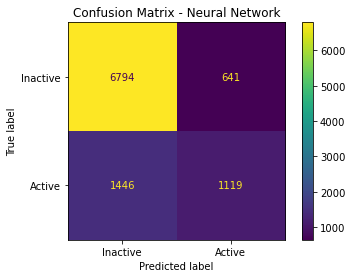

In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inactive', 'Active'])
disp.plot()
plt.title("Confusion Matrix - Neural Network")
plt.show()

The confusion matrix and classification report for the neural network model show an overall accuracy of 79.13%. The model performs well in predicting inactive users, with a precision of 82% and a recall of 91%. However, it struggles with predicting active users, achieving a lower precision of 64% and a recall of 44%. The confusion matrix highlights that the model correctly identifies a significant number of inactive users (6794) but misclassifies many active users as inactive (1446). The weighted average f1-score of 78% suggests that the model is reasonably balanced, but improvements are needed for better active user prediction.

## Summary

The Gradient Boosting Model demonstrated the highest overall accuracy at 81.55%, outperforming both the Random Forest and Neural Network models. It showed balanced performance across both inactive and active user classifications, with precision and recall values indicating a more reliable prediction for both categories. The Random Forest Model, while having a slightly lower accuracy of 79.34%, also performed well for inactive users but struggled with active users. The Neural Network Model, with an accuracy of 79.13%, showed strong precision for inactive users but had the lowest recall for active users, resulting in many misclassifications. Overall, Gradient Boosting is recommended due to its superior accuracy and balanced performance, though further enhancements are needed to improve recall for active users across all models.